# Multilayer Perceptron Neural Network - Classification

This data set is made available by SAS. It contains data about the home loans of 2,906 bank clients. Each row represents a single loan. The columns include the characteristics of the client who used the loan. Binary classification task: predict whether a loan will be bad or not (1=Yes, 0=No). This is an important task for banks to prevent bad loans from being issued.

## Goal

Use the **loan.csv** data set and build a model to predict **BAD**. 

# Read and Prepare the Data

In [38]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)

loan = pd.read_csv("loan.csv")
loan.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,27800,64804.0,97553.0,DebtCon,Other,15.0,1.0,0.0,105.098664,1.0,17.0,32.177861
1,0,20600,67086.0,108006.0,DebtCon,Office,6.0,NaN,1.0,116.328658,2.0,18.0,36.966325
2,0,25100,28778.0,50872.0,DebtCon,Other,28.0,0.0,0.0,304.195153,NaN,12.0,31.599464
3,1,12400,45604.0,65501.0,DebtCon,Other,9.0,0.0,1.0,70.337531,1.0,24.0,35.212181
4,0,27300,NaN,37531.0,HomeImp,Other,22.0,0.0,0.0,82.660269,2.0,14.0,29.609848


### Split into Train/Test

In [39]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(loan, test_size=0.3)

### Check for missing values

In [40]:
train.isna().sum()

BAD          0
LOAN         0
MORTDUE    180
VALUE       73
REASON      94
JOB         86
YOJ        166
DEROG      217
DELINQ     175
CLAGE      110
NINQ       162
CLNO        78
DEBTINC    663
dtype: int64

In [41]:
test.isna().sum()

BAD          0
LOAN         0
MORTDUE     76
VALUE       36
REASON      41
JOB         37
YOJ         73
DEROG       95
DELINQ      81
CLAGE       56
NINQ        76
CLNO        41
DEBTINC    290
dtype: int64

### Separate Target

In [42]:
train_y = train[['BAD']]
test_y = test[['BAD']]

train_inputs = train.drop(['BAD'], axis=1)
test_inputs = test.drop(['BAD'], axis=1)

#BAD is binary and no values are missing

### Identify numeric/categorical columns

In [43]:
train_inputs.dtypes

LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [44]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns

numeric_columns

Index(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC'],
      dtype='object')

In [45]:
# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns

categorical_columns

Index(['REASON', 'JOB'], dtype='object')

### Pipeline

In [46]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)])

### Transform Train and Test

In [47]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x.shape

(2034, 20)

In [48]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x.shape

(872, 20)

# Neural Network Model 1

In [49]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

mlp1 = MLPClassifier(hidden_layer_sizes=(100,75,50,25), 
                     max_iter=1000,   
                     solver='adam',
                     alpha=.1
                     )

mlp1.fit(train_x, train_y)

C:\Users\ajohnson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 75, 50, 25), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [50]:
#Check the number of iterations:
mlp1.n_iter_

145

In [51]:
#Check the number of layers:
mlp1.n_layers_

6

In [52]:
#Predict the train values
train_y_pred = mlp1.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

1.0

In [53]:
#Predict the test values
test_y_pred = mlp1.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.8681192660550459

In [54]:
confusion_matrix(test_y, test_y_pred)

array([[459,  47],
       [ 68, 298]], dtype=int64)

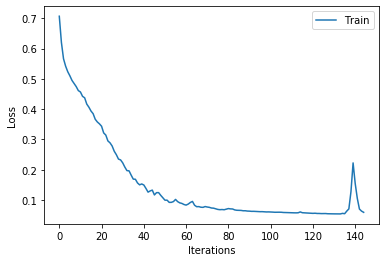

In [55]:
plt.plot(mlp1.loss_curve_, label='Train')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

# Neural Network Model 2 - Grid Search

In [60]:
from sklearn.model_selection import GridSearchCV

param_grid = {
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(100,75,50,25),(50,50,50),(100,50)],
'alpha': [.001,.01,.1],
'activation': ["identity","relu","tanh"],
'solver': ['lbfgs','sgd','adam']
}

#4-fold cross validation

GS_mlp = GridSearchCV(estimator=MLPClassifier(),
                      param_grid=param_grid,
                      n_jobs=-1,
                      cv=4, 
                      scoring='accuracy',
                      return_train_score=True,
                      verbose=True)

GS_mlp.fit(train_x, train_y)

Fitting 4 folds for each of 243 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  5.8min finished
C:\Users\ajohnson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['identity', 'relu', 'tanh'],
                         'alpha': [0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(100, 75, 50, 25), (50, 50, 50),
                        

In [61]:
#Find the best parameter set
GS_mlp.best_params_

{'activation': 'tanh',
 'alpha': 0.1,
 'hidden_layer_sizes': (100, 50),
 'learning_rate': 'constant',
 'solver': 'lbfgs'}

In [62]:
GS_mlp.best_estimator_

MLPClassifier(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [63]:
#Check the number of iterations:
GS_mlp.best_estimator_.n_iter_

201

In [64]:
#Check the number of layers:
GS_mlp.best_estimator_.n_layers_

4

In [65]:
#Predict the train values
train_y_pred = GS_mlp.best_estimator_.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

1.0

In [66]:
#Predict the test values
test_y_pred = GS_mlp.best_estimator_.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.8818807339449541

In [67]:
confusion_matrix(test_y, test_y_pred)

array([[465,  41],
       [ 62, 304]], dtype=int64)